#Autoencoders for unsupervised pretraining

We use an example to show how we can use autoencoder to improve classification results when we have limited labels.

We will use stacked autoencoders for unsuperviesed pretraining.

In [1]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Dropout
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Load mnist data.

In [3]:
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
x_train_full = x_train_full.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [4]:
print(x_train.shape, x_valid.shape, x_test.shape)

(55000, 28, 28) (5000, 28, 28) (10000, 28, 28)


In [5]:
# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_valid = np.reshape(x_valid, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

Next, we build a autoencoder using Conv2D layers.

First, we build the encoder.

In [6]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [7]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
x = Dropout(0.5)(x)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

In [8]:
# shape info needed to build decoder model

shape = K.int_shape(x)

In [9]:
shape

(None, 7, 7, 64)

In [10]:
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [11]:
# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_______________________________________________________

Now we build the decoder. Note in the decoder we use Conv2DTranspose layers.

In [12]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [13]:
# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

In [14]:
# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [15]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

In [16]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

In [18]:
# train the autoencoder
history = autoencoder.fit(x_train,
                x_train,
                validation_data=(x_valid, x_valid),
                epochs=20,
                batch_size=batch_size)

Epoch 1/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.0257 - val_loss: 0.0346
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0136 - val_loss: 0.0319
Epoch 3/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0122 - val_loss: 0.0335
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0115 - val_loss: 0.0336
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0110 - val_loss: 0.0315
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0107 - val_loss: 0.0322
Epoch 7/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0104 - val_loss: 0.0334
Epoch 8/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0103 - val_loss: 0.0343
Epoch 9/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0101 - val_loss: 0.0302
Epoch 10/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.009

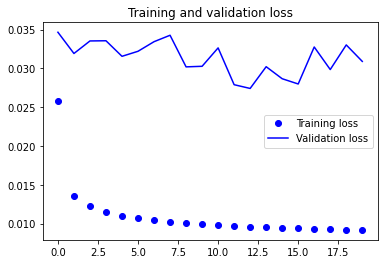

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test)

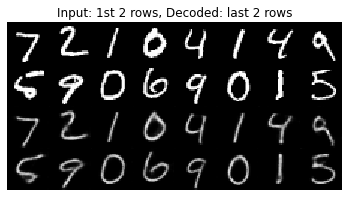

In [21]:
# display the 1st 16 test input and decoded images
imgs = np.concatenate([x_test[:16], x_decoded[:16]])
imgs = imgs.reshape((4, 8, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

In [22]:
x_encoded = encoder.predict(x_train)

In [23]:
x_encoded.shape

(55000, 16)

Let assume we only have 200 labeld images.

In [24]:
k = 200
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
rep_idx = indices[:k]

In [25]:
rep_idx

array([27244,  1614, 12702, 38054, 17430, 43482, 31505, 18498, 29075,
       49567, 43264, 11580,  2704, 23500, 17656, 42480,  4454, 20785,
       50370, 35916, 34620, 28530, 17167, 42254, 41394, 48110, 10026,
       42009, 40047, 36637, 33065, 43100, 50067,  5243, 31011, 53432,
        4709, 49621, 42163,  4289, 48444, 52588, 19281, 37900,  4855,
       43287, 23763, 30438, 44714, 25109, 50264, 44619, 11441, 21905,
       17080, 42904,  5966, 15682,  5050, 39725, 45864, 49878, 54153,
       12665, 15919, 46722, 37595, 18557, 26615, 23092, 30804, 12444,
       11948, 42834,  9542, 33564,  4131, 28033, 37061, 10380, 29043,
       50615, 38932, 38821, 45730, 48396, 48626,  3456,  3095,  3263,
       11828,   267, 54216, 46027, 46727, 47294, 29678, 52908, 34945,
       52434, 42463, 28060, 42806, 43344, 17326, 39750, 49165, 39914,
       47124,  7633, 46546, 12579, 48468,  8762, 40500,  9783, 20582,
       29924,  9632, 31624, 36192, 44874, 15028, 28908, 11776,  2129,
       37083, 11606,

In [26]:
X_rep = x_train[rep_idx]

In [27]:
y_rep = y_train[rep_idx]

In [28]:
y_rep

array([6, 2, 3, 0, 1, 3, 0, 7, 4, 2, 6, 9, 7, 6, 9, 5, 4, 8, 7, 8, 2, 9,
       9, 3, 8, 8, 0, 8, 9, 6, 2, 3, 3, 8, 3, 0, 6, 0, 7, 0, 1, 7, 4, 7,
       0, 3, 5, 0, 8, 4, 1, 0, 3, 1, 2, 6, 1, 4, 8, 5, 9, 1, 6, 0, 8, 1,
       8, 7, 5, 8, 9, 8, 0, 1, 2, 6, 7, 8, 1, 0, 2, 5, 5, 4, 1, 3, 3, 1,
       9, 9, 6, 9, 8, 3, 2, 0, 8, 6, 1, 6, 1, 5, 1, 1, 6, 9, 8, 2, 0, 2,
       2, 7, 1, 3, 7, 5, 7, 5, 4, 9, 8, 8, 0, 9, 5, 4, 2, 1, 8, 2, 1, 8,
       7, 9, 9, 1, 6, 5, 0, 1, 1, 1, 0, 9, 3, 1, 6, 9, 4, 7, 0, 2, 7, 7,
       2, 9, 0, 3, 4, 7, 1, 6, 2, 4, 2, 3, 2, 2, 2, 0, 8, 4, 6, 2, 0, 3,
       6, 1, 0, 6, 9, 7, 6, 6, 0, 8, 7, 8, 6, 9, 2, 6, 2, 0, 2, 7, 7, 8,
       3, 5], dtype=uint8)

In [29]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(y_rep)
test_labels = to_categorical(y_test)

We first use a plain Conv2D network to do the classification based on the 200 labeled samples and see what accuracy we can achieve.

In [30]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
#model.add(layers.Dense(16, activation='relu'))

In [31]:
model.add(layers.Dense(10, activation='softmax'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 21,386
Trainable params: 21,386
Non-trainable params: 0
____________________________________________________

In [33]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_rep, train_labels, epochs=20, batch_size=32)

Epoch 1/20
7/7 [==============================] - 12s 4ms/step - loss: 2.2780 - accuracy: 0.1524
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 2.1667 - accuracy: 0.4387
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 2.0551 - accuracy: 0.3524
Epoch 4/20
7/7 [==============================] - 0s 3ms/step - loss: 1.9292 - accuracy: 0.5586
Epoch 5/20
7/7 [==============================] - 0s 3ms/step - loss: 1.8247 - accuracy: 0.6316
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 1.6437 - accuracy: 0.6805
Epoch 7/20
7/7 [==============================] - 0s 3ms/step - loss: 1.4441 - accuracy: 0.6577
Epoch 8/20
7/7 [==============================] - 0s 3ms/step - loss: 1.2238 - accuracy: 0.7705
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 1.0325 - accuracy: 0.8112
Epoch 10/20
7/7 [==============================] - 0s 3ms/step - loss: 0.8945 - accuracy: 0.8000
Epoch 11/20
7/7 [=====================

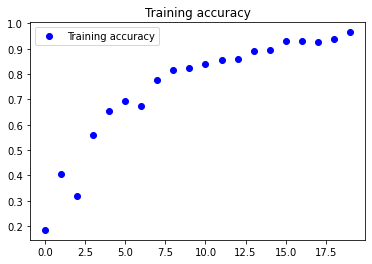

In [34]:
accuracy = history.history['accuracy']

epochs = range(len(accuracy))

plt.figure()

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()

plt.show()

In [35]:
test_loss, test_acc = model.evaluate(x_test, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.6280 - accuracy: 0.8006


We can get 80.06% of accuracy.

Now let's use autoencoder for unsupervised pretraining to convert images into lower dimensional data and use a dense neural netwrok for classification.

In [36]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(encoder)
model.layers[0].trainable = False
model.add(layers.Dense(10, activation='softmax'))

In [38]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_rep, train_labels, epochs=500, batch_size=32)

Epoch 1/500
7/7 [==============================] - 7s 3ms/step - loss: 2.9818 - accuracy: 0.0644
Epoch 2/500
7/7 [==============================] - 0s 2ms/step - loss: 2.9112 - accuracy: 0.0743
Epoch 3/500
7/7 [==============================] - 0s 3ms/step - loss: 2.8179 - accuracy: 0.0944
Epoch 4/500
7/7 [==============================] - 0s 3ms/step - loss: 2.7660 - accuracy: 0.1043
Epoch 5/500
7/7 [==============================] - 0s 2ms/step - loss: 2.7998 - accuracy: 0.0721
Epoch 6/500
7/7 [==============================] - 0s 2ms/step - loss: 2.6105 - accuracy: 0.0878
Epoch 7/500
7/7 [==============================] - 0s 2ms/step - loss: 2.6540 - accuracy: 0.1084
Epoch 8/500
7/7 [==============================] - 0s 2ms/step - loss: 2.5904 - accuracy: 0.1091
Epoch 9/500
7/7 [==============================] - 0s 2ms/step - loss: 2.4861 - accuracy: 0.1233
Epoch 10/500
7/7 [==============================] - 0s 2ms/step - loss: 2.4678 - accuracy: 0.1465
Epoch 11/500
7/7 [===========

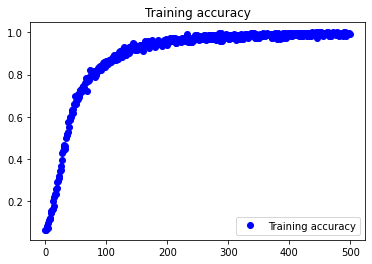

In [39]:
accuracy = history.history['accuracy']

epochs = range(len(accuracy))

plt.figure()

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()

plt.show()

In [40]:
test_loss, test_acc = model.evaluate(x_test, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.5226 - accuracy: 0.8513


We now achieve 85.15 of accuracy.

Next, we set the weights in the autoencoder to be trainalbe and see whether we can get better results.

In [41]:
model.layers[0].trainable = True
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_rep, train_labels, epochs=50, batch_size=32)

Epoch 1/50
7/7 [==============================] - 1s 4ms/step - loss: 0.0984 - accuracy: 0.9825
Epoch 2/50
7/7 [==============================] - 0s 3ms/step - loss: 0.0812 - accuracy: 0.9892
Epoch 3/50
7/7 [==============================] - 0s 3ms/step - loss: 0.0400 - accuracy: 0.9981
Epoch 4/50
7/7 [==============================] - 0s 3ms/step - loss: 0.0268 - accuracy: 0.9931
Epoch 5/50
7/7 [==============================] - 0s 3ms/step - loss: 0.0205 - accuracy: 1.0000
Epoch 6/50
7/7 [==============================] - 0s 3ms/step - loss: 0.0223 - accuracy: 1.0000
Epoch 7/50
7/7 [==============================] - 0s 3ms/step - loss: 0.0117 - accuracy: 1.0000
Epoch 8/50
7/7 [==============================] - 0s 3ms/step - loss: 0.0091 - accuracy: 1.0000
Epoch 9/50
7/7 [==============================] - 0s 3ms/step - loss: 0.0106 - accuracy: 1.0000
Epoch 10/50
7/7 [==============================] - 0s 3ms/step - loss: 0.0089 - accuracy: 0.9973
Epoch 11/50
7/7 [======================

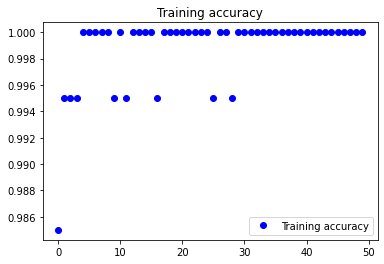

In [42]:
accuracy = history.history['accuracy']

epochs = range(len(accuracy))

plt.figure()

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()

plt.show()

In [43]:
test_loss, test_acc = model.evaluate(x_test, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.5811 - accuracy: 0.8752


This time, the accuracy is improved to 87.52%. This is much better than the result (80.06%) not using autoencoder for unsupervised pretraining.